In [1]:
import numpy as np
import tensorflow as tf
import lightgbm as lgb

from src.loaders.data_loader import load_train_data, load_test_data
from src.loaders.data_loader import generate_test_data, load_submission_data


np.random.seed(42)

In [2]:
from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
#     df = add_sin_cos_day(df)
#     df = add_sin_cos_hour(df)
    df = add_ghi(df)

#     df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(4).mean()
#     df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(6).mean()
#     df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(12).mean()
#     df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(24).mean()
#     df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(48).mean()
    
#     df["DHI_ROLLING_MEAN_3"] = df["DHI"].rolling(4).mean()
#     df["DHI_ROLLING_MEAN_5"] = df["DHI"].rolling(6).mean()
#     df["DHI_ROLLING_MEAN_11"] = df["DHI"].rolling(12).mean()
#     df["DHI_ROLLING_MEAN_23"] = df["DHI"].rolling(24).mean()
#     df["DHI_ROLLING_MEAN_47"] = df["DHI"].rolling(48).mean()
    
#     df["DNI_ROLLING_MEAN_3"] = df["DNI"].rolling(4).mean()
#     df["DNI_ROLLING_MEAN_5"] = df["DNI"].rolling(6).mean()
#     df["DNI_ROLLING_MEAN_11"] = df["DNI"].rolling(12).mean()
#     df["DNI_ROLLING_MEAN_23"] = df["DNI"].rolling(24).mean()
#     df["DNI_ROLLING_MEAN_47"] = df["DNI"].rolling(48).mean()
    
#     df["GHI_ROLLING_MEAN_3"] = df["GHI"].rolling(4).mean()
#     df["GHI_ROLLING_MEAN_5"] = df["GHI"].rolling(6).mean()
#     df["GHI_ROLLING_MEAN_11"] = df["GHI"].rolling(12).mean()
#     df["GHI_ROLLING_MEAN_23"] = df["GHI"].rolling(24).mean()
#     df["GHI_ROLLING_MEAN_47"] = df["GHI"].rolling(48).mean()
    
    scaled_rh = (df["RH"]) / 100
    _mean = df["T"].rolling(96).mean()
    _std = df["T"].rolling(96).std()
    df["SCALED_RH"] = scaled_rh * (df["T"] - _mean) / _std
    df["RH_CROSS_T"] = df["RH"] * df["T"]
    
    df.drop(["Day", "Hour", "Minute", "WS", "DHI", "RH", "T", "DNI", "GHI"], axis=1, inplace=True)
    
    return df

In [3]:
def learn(x_day, train, valid, test, columns):
    x_shape = x_day * (train.shape[2] - 1)
    print(len(columns), x_shape)
    print(columns)
    
    train_x, train_y_1, train_y_2 = train[:, :x_day, 1:].reshape(-1, x_shape), train[:, x_day:x_day + 1, target_index].reshape(-1), train[:, x_day + 1:, target_index].reshape(-1)
    valid_x, valid_y_1, valid_y_2 = valid[:, :x_day, 1:].reshape(-1, x_shape), valid[:, x_day:x_day + 1, target_index].reshape(-1), valid[:, x_day + 1:, target_index].reshape(-1)
    test_x, test_y_1, test_y_2 = test[:, :x_day, 1:].reshape(-1, x_shape), test[:, x_day:x_day + 1, target_index].reshape(-1), test[:, x_day + 1:, target_index].reshape(-1)
    
    
    train_1_dataset = lgb.Dataset(train_x, label=train_y_1, feature_name=columns)
    train_2_dataset = lgb.Dataset(train_x, label=train_y_2, feature_name=columns)
    valid_1_dataset = lgb.Dataset(valid_x, label=valid_y_1, feature_name=columns)
    valid_2_dataset = lgb.Dataset(valid_x, label=valid_y_2, feature_name=columns)
    test_1_dataset = lgb.Dataset(test_x, label=test_y_1, feature_name=columns)
    test_2_dataset = lgb.Dataset(test_x, label=test_y_2, feature_name=columns)
    
    submission_df = load_submission_data()

    r = 0
    bst_1_list = []
    bst_2_list = []
    for i in range(1, 10):
        q = i/10
        result = []
        param = {
        'application': 'quantile',
        'learning_rate': 0.05,
        'max_depth': 3,
        'num_leaves': 8,
        'n_jobs': 17,
        'seed': 42,
        'bagging_freq': 100,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'drop_rate': 0.2,
        'early_stopping_round': 10,
        'alpha': q,
        'boosting': 'gbdt',
        }
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        bst_1_list.append(bst_1)
        bst_2_list.append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        r += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        r += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
        
        for td in generate_test_data():
            td = feature_engineering(td)
            td.drop("TARGET", inplace=True, axis=1)
            td = td.values.reshape(7, 48, -1)[(7 - x_day):, :, :].transpose(1, 0, 2).reshape(48, -1)
            result.append(bst_1.predict(td))
            result.append(bst_2.predict(td))
        
        submission_df[f"q_{q}"] = np.array(result).reshape(-1)
        
    r = r/test.shape[0]
    return r/18, submission_df, bst_1_list, bst_2_list

In [4]:
import numpy as np
np.array([1, 2, 3]) - np.array([[1], [2], [3]])

array([[ 0,  1,  2],
       [-1,  0,  1],
       [-2, -1,  0]])

In [5]:
# test.shape

In [6]:
raw_df = load_train_data()

preprocessed_df = feature_engineering(raw_df)
preprocessed_df.dropna(inplace=True)
preprocessed_df.head(10)

target_index = 0
# target_index = [i for i, s in enumerate(preprocessed_df.columns) if s == "TARGET"][0]

one_day = 48
x_day = 5
one_set = one_day * (x_day + 2)


set_df = []
target_df = []
target_df = []
for i in range(0, len(preprocessed_df) - one_set + 1, 48):
    tmp = preprocessed_df[i:i + one_set].values
    
    tmp = tmp.reshape((x_day + 2), 48, -1)
    tmp = tmp.transpose(1, 0, 2)
    x = tmp[:, :x_day, :]
    y = tmp[:, x_day:, :]
    
    for j in range(48):
        set_df.append(x[j, :, :])
        target_df.append(y[j, :, :])
           
set_df = np.array(set_df)
target_df = np.array(target_df)
set_df.shape, target_df.shape

all_df = np.concatenate((set_df, target_df), axis=1)

train = []
valid = []
test = []

length = all_df.shape[0]
boundary = [
    (slice(0, int(length * 0.6)),slice(int(length * 0.6), int(length * 0.9)), slice(int(length * 0.9), int(length * 1.0))),
    (slice(int(length * 0.1), int(length * 0.7)),slice(int(length * 0.7), int(length * 1)), slice(int(length * 0), int(length * 0.1))),    
    (slice(int(length * 0.3), int(length * 0.9)),slice(int(length * 0.9), int(length * 1)), slice(int(length * 0), int(length * 0.3))),
    (slice(int(length * 0.4), int(length * 1)),slice(int(length * 0), int(length * 0.3)), slice(int(length * 0.3), int(length * 0.4))),
]
boundary = [
    (slice(0, int(length * 0.8)),slice(int(length * 0.8), int(length * 0.9)), slice(int(length * 0.9), int(length * 1.0))),
    (slice(int(length * 0.1), int(length * 0.9)),slice(int(length * 0.9), int(length * 1)), slice(int(length * 0), int(length * 0.1))),    
    (slice(int(length * 0.2), int(length * 1)),slice(int(length * 0), int(length * 0.1)), slice(int(length * 0.1), int(length * 0.2))),
]
boundary = [
    (slice(0, int(length * 0.5)),slice(int(length * 0.5), int(length * 0.8)), slice(int(length * 0.8), int(length * 1.0))),
    (slice(int(length * 0.5), int(length * 1)),slice(int(length * 0), int(length * 0.3)), slice(int(length * 0.3), int(length * 0.5))),    
]

total_error = 0
result_list = []
result_bst_list_1 = []
result_bst_list_2 = []

for train_slice, valid_slice, test_slice in boundary:
    train, valid, test = all_df[train_slice], all_df[valid_slice], all_df[test_slice]
    
    columns = [f"{day}_{column}" for day in range(x_day) for column in preprocessed_df.columns if column != "TARGET"]
    
    error, result_df, result_bst_1, result_bst_2 = learn(x_day, train, valid, test, columns)
    total_error += error
    result_list.append(result_df)
    result_bst_list_1.append(result_bst_1)
    result_bst_list_2.append(result_bst_2)
    

10 10
['0_SCALED_RH', '0_RH_CROSS_T', '1_SCALED_RH', '1_RH_CROSS_T', '2_SCALED_RH', '2_RH_CROSS_T', '3_SCALED_RH', '3_RH_CROSS_T', '4_SCALED_RH', '4_RH_CROSS_T']
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 1.74827
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 1.74465
[3]	valid_0's quantile: 1.73732
[4]	valid_0's quantile: 1.73227
[5]	valid_0's quantile: 1.72377
[6]	valid_0's quantile: 1.71733
[7]	valid_0's quantile: 1.71519
[8]	valid_0's quantile: 1.71189
[9]	valid_0's quantile: 1.70466
[10]	valid_0's quantile: 1.69924
[11]	valid_0's quantile: 1.69496
[12]	valid_0's quantile: 1.69041
[13]	valid_0's quantile: 1.68733
[14]	valid_0's quantile: 1.68311
[15]	valid_0's quantile: 1.67818

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[58]	valid_0's quantile: 1.622
[59]	valid_0's quantile: 1.62103
[60]	valid_0's quantile: 1.62066
[61]	valid_0's quantile: 1.62028
[62]	valid_0's quantile: 1.62
[63]	valid_0's quantile: 1.61985
[64]	valid_0's quantile: 1.6196
[65]	valid_0's quantile: 1.61982
[66]	valid_0's quantile: 1.61997
[67]	valid_0's quantile: 1.61968
[68]	valid_0's quantile: 1.61926
[69]	valid_0's quantile: 1.61915
[70]	valid_0's quantile: 1.61934
[71]	valid_0's quantile: 1.61908
[72]	valid_0's quantile: 1.61868
[73]	valid_0's quantile: 1.61887
[74]	valid_0's quantile: 1.61889
[75]	valid_0's quantile: 1.61867
[76]	valid_0's quantile: 1.61807
[77]	valid_0's quantile: 1.61745
[78]	valid_0's quantile: 1.61676
[79]	valid_0's quantile: 1.61597
[80]	valid_0's quantile: 1.61568
[81]	valid_0's quantile: 1.61534
[82]	valid_0's quantile: 1.6152
[83]	valid_0's quantile: 1.61538
[84]	valid_0's quantile: 1.61524
[85]	valid_0's quantile: 1.61472
[86]	valid_0's quantile: 1.61441
[87]	valid_0's quantile: 1.61392
[88]	valid_0's qu

[40]	valid_0's quantile: 2.9276
[41]	valid_0's quantile: 2.92176
[42]	valid_0's quantile: 2.91946
[43]	valid_0's quantile: 2.91918
[44]	valid_0's quantile: 2.91827
[45]	valid_0's quantile: 2.91284
[46]	valid_0's quantile: 2.90961
[47]	valid_0's quantile: 2.90841
[48]	valid_0's quantile: 2.90468
[49]	valid_0's quantile: 2.90428
[50]	valid_0's quantile: 2.9001
[51]	valid_0's quantile: 2.8979
[52]	valid_0's quantile: 2.89517
[53]	valid_0's quantile: 2.89375
[54]	valid_0's quantile: 2.89344
[55]	valid_0's quantile: 2.89322
[56]	valid_0's quantile: 2.89213
[57]	valid_0's quantile: 2.89242
[58]	valid_0's quantile: 2.89142
[59]	valid_0's quantile: 2.89105
[60]	valid_0's quantile: 2.88836
[61]	valid_0's quantile: 2.88753
[62]	valid_0's quantile: 2.8876
[63]	valid_0's quantile: 2.88763
[64]	valid_0's quantile: 2.8867
[65]	valid_0's quantile: 2.88674
[66]	valid_0's quantile: 2.88598
[67]	valid_0's quantile: 2.88573
[68]	valid_0's quantile: 2.88582
[69]	valid_0's quantile: 2.88429
[70]	valid_0's 

[136]	valid_0's quantile: 3.71216
[137]	valid_0's quantile: 3.71197
[138]	valid_0's quantile: 3.71195
[139]	valid_0's quantile: 3.71177
[140]	valid_0's quantile: 3.71131
[141]	valid_0's quantile: 3.71093
[142]	valid_0's quantile: 3.71131
[143]	valid_0's quantile: 3.71134
[144]	valid_0's quantile: 3.71122
[145]	valid_0's quantile: 3.71112
[146]	valid_0's quantile: 3.71107
[147]	valid_0's quantile: 3.71011
[148]	valid_0's quantile: 3.71011
[149]	valid_0's quantile: 3.71003
[150]	valid_0's quantile: 3.71024
[151]	valid_0's quantile: 3.71003
[152]	valid_0's quantile: 3.71022
[153]	valid_0's quantile: 3.71023
[154]	valid_0's quantile: 3.70995
[155]	valid_0's quantile: 3.71006
[156]	valid_0's quantile: 3.71043
[157]	valid_0's quantile: 3.71019
[158]	valid_0's quantile: 3.71026
[159]	valid_0's quantile: 3.70947
[160]	valid_0's quantile: 3.70934
[161]	valid_0's quantile: 3.70938
[162]	valid_0's quantile: 3.7093
[163]	valid_0's quantile: 3.70924
[164]	valid_0's quantile: 3.70904
[165]	valid_0's

[445]	valid_0's quantile: 3.67202
[446]	valid_0's quantile: 3.67077
[447]	valid_0's quantile: 3.67037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[448]	valid_0's quantile: 3.67036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[449]	valid_0's quantile: 3.67035
[450]	valid_0's quantile: 3.66999
[451]	valid_0's quantile: 3.66855
[452]	valid_0's quantile: 3.66789
[453]	valid_0's quantile: 3.6679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[454]	valid_0's quantile: 3.668
[455]	valid_0's quantile: 3.66749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[456]	valid_0's quantile: 3.66762
[457]	valid_0's quantile: 3.66793
[458]	valid_0's quantile: 3.66808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[459]	valid_0's quantile: 3.66815
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[460]	valid_0's quantile: 3.66826
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 6.81056
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 6.63032
[3]	valid_0's quantile: 6.46192
[4]	valid_0's quantile: 6.29251
[5]	valid_0's quantile: 6.14269
[6]	valid_0's quantile: 6.00621
[7]	valid_0's quantile: 5.8725
[8]	valid_0's quantile: 5.76037
[9]	valid_0's quantile: 5.65142
[10]	valid_0's quantile: 5.54997
[11]	valid_0's quantile: 5.45714
[12]	valid_0's quantile: 5.37202
[13]	valid_0's quantile: 5.28929
[14]	valid_0's quantile: 5.21764
[15]	valid_0's quantile: 5.14822
[16]	valid_0's quantile: 5.08895
[17]	valid_0's quantile: 5.03181
[18]	valid_0's quantile: 4.97792
[19]	valid_0's quantile: 4.92582
[20]	valid_0's quantile: 4.879

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 8.42491
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.12817
[3]	valid_0's quantile: 7.8355
[4]	valid_0's quantile: 7.56894
[5]	valid_0's quantile: 7.32057
[6]	valid_0's quantile: 7.0908
[7]	valid_0's quantile: 6.87751
[8]	valid_0's quantile: 6.68516
[9]	valid_0's quantile: 6.50232
[10]	valid_0's quantile: 6.34208
[11]	valid_0's quantile: 6.20149
[12]	valid_0's quantile: 6.07172
[13]	valid_0's quantile: 5.94991
[14]	valid_0's quantile: 5.83787
[15]	valid_0's quantile: 5.73238
[16]	valid_0's quantile: 5.63508
[17]	valid_0's quantile: 5.55218
[18]	valid_0's quantile: 5.47147
[19]	valid_0's quantile: 5.40332
[20]	valid_0's quantile: 5.3335

[76]	valid_0's quantile: 4.52766
[77]	valid_0's quantile: 4.52573
[78]	valid_0's quantile: 4.52508
[79]	valid_0's quantile: 4.52267
[80]	valid_0's quantile: 4.51991
[81]	valid_0's quantile: 4.51989
[82]	valid_0's quantile: 4.51771
[83]	valid_0's quantile: 4.51582
[84]	valid_0's quantile: 4.51434
[85]	valid_0's quantile: 4.51237
[86]	valid_0's quantile: 4.51188
[87]	valid_0's quantile: 4.50982
[88]	valid_0's quantile: 4.50853
[89]	valid_0's quantile: 4.50712
[90]	valid_0's quantile: 4.50685
[91]	valid_0's quantile: 4.50608
[92]	valid_0's quantile: 4.50565
[93]	valid_0's quantile: 4.50495
[94]	valid_0's quantile: 4.50344
[95]	valid_0's quantile: 4.50284
[96]	valid_0's quantile: 4.50255
[97]	valid_0's quantile: 4.50239
[98]	valid_0's quantile: 4.50202
[99]	valid_0's quantile: 4.5019
[100]	valid_0's quantile: 4.50134
[101]	valid_0's quantile: 4.50099
[102]	valid_0's quantile: 4.50034
[103]	valid_0's quantile: 4.50037
[104]	valid_0's quantile: 4.50014
[105]	valid_0's quantile: 4.50017
[106]

[141]	valid_0's quantile: 4.3824
[142]	valid_0's quantile: 4.38209
[143]	valid_0's quantile: 4.38126
[144]	valid_0's quantile: 4.38082
[145]	valid_0's quantile: 4.38026
[146]	valid_0's quantile: 4.38019
[147]	valid_0's quantile: 4.37991
[148]	valid_0's quantile: 4.37984
[149]	valid_0's quantile: 4.37981
[150]	valid_0's quantile: 4.37996
[151]	valid_0's quantile: 4.37951
[152]	valid_0's quantile: 4.3793
[153]	valid_0's quantile: 4.37904
[154]	valid_0's quantile: 4.37871
[155]	valid_0's quantile: 4.37941
[156]	valid_0's quantile: 4.37949
[157]	valid_0's quantile: 4.37938
[158]	valid_0's quantile: 4.37908
[159]	valid_0's quantile: 4.37924
[160]	valid_0's quantile: 4.37898
[161]	valid_0's quantile: 4.37876
[162]	valid_0's quantile: 4.37874
[163]	valid_0's quantile: 4.37873
[164]	valid_0's quantile: 4.37853
[165]	valid_0's quantile: 4.37851
[166]	valid_0's quantile: 4.3785
[167]	valid_0's quantile: 4.37821
[168]	valid_0's quantile: 4.37795
[169]	valid_0's quantile: 4.37799
[170]	valid_0's q

[327]	valid_0's quantile: 3.96935
[328]	valid_0's quantile: 3.9694
[329]	valid_0's quantile: 3.96921
[330]	valid_0's quantile: 3.96915
[331]	valid_0's quantile: 3.96915
[332]	valid_0's quantile: 3.96915
[333]	valid_0's quantile: 3.96854
[334]	valid_0's quantile: 3.9688
[335]	valid_0's quantile: 3.96904
[336]	valid_0's quantile: 3.96904
[337]	valid_0's quantile: 3.96904
[338]	valid_0's quantile: 3.96904
[339]	valid_0's quantile: 3.96904
[340]	valid_0's quantile: 3.96906
[341]	valid_0's quantile: 3.96904
[342]	valid_0's quantile: 3.96901
[343]	valid_0's quantile: 3.969
Early stopping, best iteration is:
[333]	valid_0's quantile: 3.96854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 23.647898
[1]	valid_0

[330]	valid_0's quantile: 3.29729
[331]	valid_0's quantile: 3.29729
[332]	valid_0's quantile: 3.29724
[333]	valid_0's quantile: 3.29717
[334]	valid_0's quantile: 3.2971
[335]	valid_0's quantile: 3.29726
[336]	valid_0's quantile: 3.2973
[337]	valid_0's quantile: 3.29728
[338]	valid_0's quantile: 3.2972
[339]	valid_0's quantile: 3.2972
[340]	valid_0's quantile: 3.29706
[341]	valid_0's quantile: 3.29707
[342]	valid_0's quantile: 3.29694
[343]	valid_0's quantile: 3.29688
[344]	valid_0's quantile: 3.29676
[345]	valid_0's quantile: 3.29676
[346]	valid_0's quantile: 3.29657
[347]	valid_0's quantile: 3.29651
[348]	valid_0's quantile: 3.29652
[349]	valid_0's quantile: 3.2965
[350]	valid_0's quantile: 3.29652
[351]	valid_0's quantile: 3.29663
[352]	valid_0's quantile: 3.29665
[353]	valid_0's quantile: 3.29665
[354]	valid_0's quantile: 3.29646
[355]	valid_0's quantile: 3.29641
[356]	valid_0's quantile: 3.29559
[357]	valid_0's quantile: 3.29467
[358]	valid_0's quantile: 3.29467
[359]	valid_0's qua

[145]	valid_0's quantile: 3.32234
[146]	valid_0's quantile: 3.32135
[147]	valid_0's quantile: 3.32105
[148]	valid_0's quantile: 3.32105
[149]	valid_0's quantile: 3.32087
[150]	valid_0's quantile: 3.32066
[151]	valid_0's quantile: 3.32069
[152]	valid_0's quantile: 3.32052
[153]	valid_0's quantile: 3.32015
[154]	valid_0's quantile: 3.31978
[155]	valid_0's quantile: 3.31939
[156]	valid_0's quantile: 3.31925
[157]	valid_0's quantile: 3.31914
[158]	valid_0's quantile: 3.3189
[159]	valid_0's quantile: 3.31828
[160]	valid_0's quantile: 3.31821
[161]	valid_0's quantile: 3.31769
[162]	valid_0's quantile: 3.31766
[163]	valid_0's quantile: 3.31763
[164]	valid_0's quantile: 3.31751
[165]	valid_0's quantile: 3.31753
[166]	valid_0's quantile: 3.31747
[167]	valid_0's quantile: 3.31711
[168]	valid_0's quantile: 3.31712
[169]	valid_0's quantile: 3.31698
[170]	valid_0's quantile: 3.31621
[171]	valid_0's quantile: 3.3161
[172]	valid_0's quantile: 3.31578
[173]	valid_0's quantile: 3.31572
[174]	valid_0's 

[318]	valid_0's quantile: 2.15193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[319]	valid_0's quantile: 2.1511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's quantile: 2.15107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's quantile: 2.15102
[322]	valid_0's quantile: 2.14996
[323]	valid_0's quantile: 2.14984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's quantile: 2.14865
[325]	valid_0's quantile: 2.1485
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 2.14851
[327]	valid_0's quantile: 2.14818
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's quantile: 2.14728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's quantile: 2.14701
[330]	valid_0's quantile: 2.14697
[331]	valid_0's quantile: 2.14697
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's quantile: 2.18027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's quantile: 2.18027
[251]	valid_0's quantile: 2.18026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[252]	valid_0's quantile: 2.17934
[253]	valid_0's quantile: 2.1793
[254]	valid_0's quantile: 2.17931
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's quantile: 2.17842
[256]	valid_0's quantile: 2.17832
[257]	valid_0's quantile: 2.17828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's quantile: 2.17827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's quantile: 2.1769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's quantile: 2.17597
[LightGBM] [Warning] No further splits with positive gain, best gain:

[558]	valid_0's quantile: 2.1236
[559]	valid_0's quantile: 2.12328
[560]	valid_0's quantile: 2.12299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[561]	valid_0's quantile: 2.12301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[562]	valid_0's quantile: 2.12301
[563]	valid_0's quantile: 2.12252
[564]	valid_0's quantile: 2.12253
[565]	valid_0's quantile: 2.12231
[566]	valid_0's quantile: 2.12196
[567]	valid_0's quantile: 2.12144
[568]	valid_0's quantile: 2.12097
[569]	valid_0's quantile: 2.12057
[570]	valid_0's quantile: 2.12057
[571]	valid_0's quantile: 2.12056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's quantile: 2.1205
[573]	valid_0's quantile: 2.12016
[574]	valid_0's quantile: 2.12015
[575]	valid_0's quantile: 2.12001
[576]	valid_0's quantile: 2.11968
[577]	valid_0's quantile: 2.11925
[578]	valid_0's quantile: 2.11927
[579]	valid_0's quantile: 2.11931
[580]	valid_0's quantile: 2.1

[66]	valid_0's quantile: 1.66146
[67]	valid_0's quantile: 1.66138
[68]	valid_0's quantile: 1.661
[69]	valid_0's quantile: 1.66096
[70]	valid_0's quantile: 1.66075
[71]	valid_0's quantile: 1.66046
[72]	valid_0's quantile: 1.66015
[73]	valid_0's quantile: 1.66022
[74]	valid_0's quantile: 1.65999
[75]	valid_0's quantile: 1.65994
[76]	valid_0's quantile: 1.65971
[77]	valid_0's quantile: 1.65968
[78]	valid_0's quantile: 1.65961
[79]	valid_0's quantile: 1.65972
[80]	valid_0's quantile: 1.65956
[81]	valid_0's quantile: 1.65953
[82]	valid_0's quantile: 1.65966
[83]	valid_0's quantile: 1.65963
[84]	valid_0's quantile: 1.65985
[85]	valid_0's quantile: 1.66025
[86]	valid_0's quantile: 1.66068
[87]	valid_0's quantile: 1.66068
[88]	valid_0's quantile: 1.6608
[89]	valid_0's quantile: 1.66113
[90]	valid_0's quantile: 1.6615
[91]	valid_0's quantile: 1.6613
Early stopping, best iteration is:
[81]	valid_0's quantile: 1.65953
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of te

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 5.36503
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.25173
[3]	valid_0's quantile: 5.14794
[4]	valid_0's quantile: 5.04871
[5]	valid_0's quantile: 4.95876
[6]	valid_0's quantile: 4.87061
[7]	valid_0's quantile: 4.79902
[8]	valid_0's quantile: 4.72565
[9]	valid_0's quantile: 4.65608
[10]	valid_0's quantile: 4.59856
[11]	valid_0's quantile: 4.54391
[12]	valid_0's quantile: 4.49466
[13]	valid_0's quantile: 4.44571
[14]	valid_0's quantile: 4.39788
[15]	valid_0's quantile: 4.35692
[16]	valid_0's quantile: 4.33087
[17]	valid_0's quantile: 4.2961
[18]	valid_0's quantile: 4.26351
[19]	valid_0's quantile: 4.23485
[20]	valid_0's quantile: 4.209

[73]	valid_0's quantile: 3.97494
[74]	valid_0's quantile: 3.97392
[75]	valid_0's quantile: 3.97393
[76]	valid_0's quantile: 3.97367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 3.97367
[78]	valid_0's quantile: 3.97054
[79]	valid_0's quantile: 3.97048
[80]	valid_0's quantile: 3.97033
[81]	valid_0's quantile: 3.96943
[82]	valid_0's quantile: 3.96957
[83]	valid_0's quantile: 3.96958
[84]	valid_0's quantile: 3.96956
[85]	valid_0's quantile: 3.96969
[86]	valid_0's quantile: 3.96968
[87]	valid_0's quantile: 3.96896
[88]	valid_0's quantile: 3.96906
[89]	valid_0's quantile: 3.96919
[90]	valid_0's quantile: 3.96919
[91]	valid_0's quantile: 3.9692
[92]	valid_0's quantile: 3.9692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 3.96942
[94]	valid_0's quantile: 3.97063
[95]	valid_0's quantile: 3.97061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[96]	valid_0's qua

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[1]	valid_0's quantile: 8.7777
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.44659
[3]	valid_0's quantile: 8.13924
[4]	valid_0's quantile: 7.86325
[5]	valid_0's quantile: 7.59823
[6]	valid_0's quantile: 7.36242
[7]	valid_0's quantile: 7.15184
[8]	valid_0's quantile: 6.95055
[9]	valid_0's quantile: 6.77183
[10]	valid_0's quantile: 6.6035
[11]	valid_0's quantile: 6.45869
[12]	valid_0's quantile: 6.32105
[13]	valid_0's quantile: 6.20027
[14]	valid_0's quantile: 6.09157
[15]	valid_0's quantile: 5.98317
[16]	valid_0's quantile: 5.89182
[17]	valid_0's quantile: 5.80558
[18]	valid_0's quantile: 5.72735
[19]	valid_0's quantile: 5.65198
[20]	valid_0's quantile: 5.5851

[127]	valid_0's quantile: 4.82308
[128]	valid_0's quantile: 4.82301
[129]	valid_0's quantile: 4.82297
[130]	valid_0's quantile: 4.82302
[131]	valid_0's quantile: 4.82187
[132]	valid_0's quantile: 4.82172
[133]	valid_0's quantile: 4.82196
[134]	valid_0's quantile: 4.82176
[135]	valid_0's quantile: 4.82191
[136]	valid_0's quantile: 4.82204
[137]	valid_0's quantile: 4.82218
[138]	valid_0's quantile: 4.82205
[139]	valid_0's quantile: 4.82196
[140]	valid_0's quantile: 4.82211
[141]	valid_0's quantile: 4.82211
[142]	valid_0's quantile: 4.82199
Early stopping, best iteration is:
[132]	valid_0's quantile: 4.82172
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 8.632183
[1]	valid_0's quantile: 10.0774
Training u

[132]	valid_0's quantile: 4.70464
[133]	valid_0's quantile: 4.70444
[134]	valid_0's quantile: 4.70409
[135]	valid_0's quantile: 4.70398
[136]	valid_0's quantile: 4.70369
[137]	valid_0's quantile: 4.70343
[138]	valid_0's quantile: 4.70358
[139]	valid_0's quantile: 4.70283
[140]	valid_0's quantile: 4.70231
[141]	valid_0's quantile: 4.70232
[142]	valid_0's quantile: 4.7019
[143]	valid_0's quantile: 4.70191
[144]	valid_0's quantile: 4.70131
[145]	valid_0's quantile: 4.70114
[146]	valid_0's quantile: 4.70115
[147]	valid_0's quantile: 4.70105
[148]	valid_0's quantile: 4.70102
[149]	valid_0's quantile: 4.69801
[150]	valid_0's quantile: 4.69657
[151]	valid_0's quantile: 4.69644
[152]	valid_0's quantile: 4.69639
[153]	valid_0's quantile: 4.69631
[154]	valid_0's quantile: 4.69626
[155]	valid_0's quantile: 4.69618
[156]	valid_0's quantile: 4.69573
[157]	valid_0's quantile: 4.69571
[158]	valid_0's quantile: 4.69569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	va

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000355 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 26088, number of used features: 10
[LightGBM] [Info] Start training from score 23.554470
[1]	valid_0's quantile: 10.2632
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.85427
[3]	valid_0's quantile: 9.46813
[4]	valid_0's quantile: 9.11204
[5]	valid_0's quantile: 8.77533
[6]	valid_0's quantile: 8.46751
[7]	valid_0's quantile: 8.18928
[8]	valid_0's quantile: 7.92574
[9]	valid_0's quantile: 7.68109
[10]	valid_0's quantile: 7.44506
[11]	valid_0's quantile: 7.23046
[12]	valid_0's quantile: 7.02865
[13]	valid_0's quantile: 6.84638
[14]	valid_0's quantile: 6.66428
[15]	valid_0's quantile: 6.50407
[16]	valid_0's quantile: 6.35713
[17]	valid_0's quantile: 6.21663
[18]	valid_0's quantile: 6.08571
[19]	val

[77]	valid_0's quantile: 4.30456
[78]	valid_0's quantile: 4.30157
[79]	valid_0's quantile: 4.29858
[80]	valid_0's quantile: 4.2958
[81]	valid_0's quantile: 4.29324
[82]	valid_0's quantile: 4.29084
[83]	valid_0's quantile: 4.28843
[84]	valid_0's quantile: 4.28615
[85]	valid_0's quantile: 4.28415
[86]	valid_0's quantile: 4.2822
[87]	valid_0's quantile: 4.2804
[88]	valid_0's quantile: 4.27862
[89]	valid_0's quantile: 4.27699
[90]	valid_0's quantile: 4.27487
[91]	valid_0's quantile: 4.27317
[92]	valid_0's quantile: 4.27171
[93]	valid_0's quantile: 4.2702
[94]	valid_0's quantile: 4.26878
[95]	valid_0's quantile: 4.26758
[96]	valid_0's quantile: 4.26664
[97]	valid_0's quantile: 4.26555
[98]	valid_0's quantile: 4.26479
[99]	valid_0's quantile: 4.26354
[100]	valid_0's quantile: 4.26269
[101]	valid_0's quantile: 4.26177
[102]	valid_0's quantile: 4.26107
[103]	valid_0's quantile: 4.26026
[104]	valid_0's quantile: 4.25967
[105]	valid_0's quantile: 4.25947
[106]	valid_0's quantile: 4.25953
[107]	v

[169]	valid_0's quantile: 3.43694
[170]	valid_0's quantile: 3.43701
[171]	valid_0's quantile: 3.43704
[172]	valid_0's quantile: 3.43723
[173]	valid_0's quantile: 3.43723
[174]	valid_0's quantile: 3.43725
[175]	valid_0's quantile: 3.43689
[176]	valid_0's quantile: 3.43658
[177]	valid_0's quantile: 3.4365
[178]	valid_0's quantile: 3.43652
[179]	valid_0's quantile: 3.43654
[180]	valid_0's quantile: 3.43653
[181]	valid_0's quantile: 3.43643
[182]	valid_0's quantile: 3.43635
[183]	valid_0's quantile: 3.4364
[184]	valid_0's quantile: 3.43642
[185]	valid_0's quantile: 3.43643
[186]	valid_0's quantile: 3.43635
[187]	valid_0's quantile: 3.43628
[188]	valid_0's quantile: 3.43689
[189]	valid_0's quantile: 3.43588
[190]	valid_0's quantile: 3.43618
[191]	valid_0's quantile: 3.43624
[192]	valid_0's quantile: 3.43626
[193]	valid_0's quantile: 3.43617
[194]	valid_0's quantile: 3.43605
[195]	valid_0's quantile: 3.43384
[196]	valid_0's quantile: 3.43379
[197]	valid_0's quantile: 3.43313
[198]	valid_0's 

[311]	valid_0's quantile: 2.14112
[312]	valid_0's quantile: 2.14114
[313]	valid_0's quantile: 2.14137
[314]	valid_0's quantile: 2.14103
[315]	valid_0's quantile: 2.1411
[316]	valid_0's quantile: 2.14114
[317]	valid_0's quantile: 2.14114
[318]	valid_0's quantile: 2.14116
[319]	valid_0's quantile: 2.14092
[320]	valid_0's quantile: 2.14098
[321]	valid_0's quantile: 2.14087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's quantile: 2.14088
[323]	valid_0's quantile: 2.14064
[324]	valid_0's quantile: 2.14023
[325]	valid_0's quantile: 2.14022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 2.14029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's quantile: 2.14023
[328]	valid_0's quantile: 2.14002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's quantile: 2.14001
[LightGBM] [Warning] No further splits with positive ga

In [7]:
total_error/ len(boundary)

3.588311827487448

In [8]:
preprocessed_df.head(5)

,TARGET,SCALED_RH,RH_CROSS_T
95,0.0,-0.151448,-579.92
96,0.0,-0.162890,-590.40
97,0.0,-0.158719,-545.60
98,0.0,-0.169167,-552.48
99,0.0,-0.177725,-552.32


In [9]:
submission_df = load_submission_data()

for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / len(boundary)

In [10]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.017013,0.069893,0.182861
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007939,0.069586,0.114636
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007709,0.053027,0.261100
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.007709,0.055173,0.083986
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.005707,0.055168,0.024381
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.004237,0.029166,0.132568
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001785,0.029246,0.165747
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001784,0.032990,0.256304
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001784,0.035901,0.262851
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.002960,0.001782,0.031393,0.227866


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

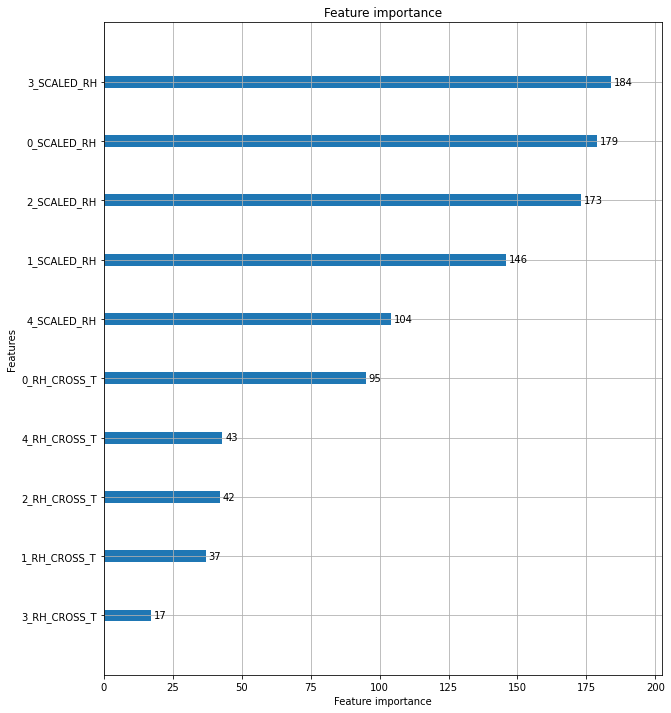

In [11]:
lgb.plot_importance(result_bst_1[0], figsize=(10, 12))

In [1]:
submission_df.to_csv("lightgbm_gbdt_split_dataset_2021_01_14_1.csv", index=False)

NameError: name 'submission_df' is not defined

In [1]:
from src.loaders.data_loader import load_train_data, load_submission_data
from src.preprocessors.splitors import split_train_valid_test_for_cv, split_x_y_for_lightgbm_train
from src.preprocessors.add_columns import add_ghi, add_rolling_mean, add_rolling_mean_bulk
from src.preprocessors.feature_engineering import feature_engineering_lightgbm
from src.preprocessors.dataset_creators import create_lightgbm_dataset
from src.make_submissions.create_submission import create_submission_using_lightgbm_model

import lightgbm as lgb
import numpy as np

In [2]:
df = load_train_data()

In [3]:
def get_lightgbm_param(q):
    param = {
            'application': 'quantile',
            'learning_rate': 0.05,
            'max_depth': 3,
            'num_leaves': 8,
            'n_jobs': 17,
            'seed': 42,
            'bagging_freq': 100,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'drop_rate': 0.2,
            'early_stopping_round': 10,
            'alpha': q,
            'boosting': 'gbdt',
        }
    return param

days = 5


In [4]:
feature_engineered_df = feature_engineering_lightgbm(df)
feature_engineered_df.head(5)

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET,GHI,...,DNI_rolling_mean_4,DNI_rolling_mean_8,DNI_rolling_mean_12,DNI_rolling_mean_24,DNI_rolling_mean_48,GHI_rolling_mean_4,GHI_rolling_mean_8,GHI_rolling_mean_12,GHI_rolling_mean_24,GHI_rolling_mean_48
0,0,0,0,0,0,1.5,69.08,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,30,0,0,1.5,69.06,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,1,0,0,0,1.6,71.78,-12,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,30,0,0,1.6,71.75,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
4,0,2,0,0,0,1.6,75.20,-12,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


In [5]:
selector = [
    "4_GHI",
    "4_TARGET_rolling_mean_24",
    "4_TARGET_rolling_mean_48",
]

In [ ]:
history = {
    "total_error": 0
}

for train, valid, test in split_train_valid_test_for_cv(feature_engineered_df, 0.5):
    train_1_dataset, train_2_dataset = create_lightgbm_dataset(train, days, selector)
    valid_1_dataset, valid_2_dataset = create_lightgbm_dataset(valid, days, selector)
    test_x, test_y_1, test_y_2, c = split_x_y_for_lightgbm_train(test, days)
    test_x = test_x[selector]
    submission_df = load_submission_data()
    
    for i in range(1, 10):
        q = i/10
        history[q] = {"bst_1": [], "bst_2": []}
        param = get_lightgbm_param(q)
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        history[q]["bst_1"].append(bst_1)
        history[q]["bst_2"].append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x).reshape(-1)
        y_pred_2 = bst_2.predict(test_x).reshape(-1)

        history["total_error"] += np.sum(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        history["total_error"] += np.sum(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
                
        submission_df[f"q_{q}"] = create_submission_using_lightgbm_model(selector, bst_1, bst_2, days)

history["total_error"] /= feature_engineered_df.shape[0]

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[1]	valid_0's quantile: 1.72836
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 1.71193
[3]	valid_0's quantile: 1.69227
[4]	valid_0's quantile: 1.67152
[5]	valid_0's quantile: 1.65254
[6]	valid_0's quantile: 1.63397
[7]	valid_0's quantile: 1.61861
[8]	valid_0's quantile: 1.60364
[9]	valid_0's quantile: 1.58988
[10]	valid_0's quantile: 1.57689
[11]	valid_0's quantile: 1.56492
[12]	valid_0's quantile: 1.55414
[13]	valid_0's quantile: 1.54378
[14]	valid_0's quantile: 1.53461
[15]	valid_0's quantile: 1.52616
[16]	valid_0's quantile: 1.51922
[17]	valid_0's quantile: 1.51283
[18]	valid_0's quantile: 1.50571


[126]	valid_0's quantile: 1.46306
[127]	valid_0's quantile: 1.46316
[128]	valid_0's quantile: 1.46316
[129]	valid_0's quantile: 1.46302
[130]	valid_0's quantile: 1.4631
[131]	valid_0's quantile: 1.4631
[132]	valid_0's quantile: 1.46297
[133]	valid_0's quantile: 1.46299
[134]	valid_0's quantile: 1.46299
[135]	valid_0's quantile: 1.46312
[136]	valid_0's quantile: 1.46324
[137]	valid_0's quantile: 1.46336
[138]	valid_0's quantile: 1.46345
[139]	valid_0's quantile: 1.46355
[140]	valid_0's quantile: 1.46365
[141]	valid_0's quantile: 1.4636
[142]	valid_0's quantile: 1.46362
Early stopping, best iteration is:
[132]	valid_0's quantile: 1.46297


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[1]	valid_0's quantile: 3.42893
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 3.35621
[3]	valid_0's quantile: 3.28361
[4]	valid_0's quantile: 3.21439
[5]	valid_0's quantile: 3.15003
[6]	valid_0's quantile: 3.09125
[7]	valid_0's quantile: 3.03423
[8]	valid_0's quantile: 2.98067
[9]	valid_0's quantile: 2.93927
[10]	valid_0's quantile: 2.89957
[11]	valid_0's quantile: 2.85913
[12]	valid_0's quantile: 2.81924
[13]	valid_0's quantile: 2.78615
[14]	valid_0's quantile: 2.75537
[15]	valid_0's quantile: 2.72406
[16]	valid_0's quantile: 2.6957
[17]	valid_0's quantile: 2.66647
[18]	valid_0's quantile: 2.64416
[

[117]	valid_0's quantile: 2.48419
[118]	valid_0's quantile: 2.48417
[119]	valid_0's quantile: 2.48407
[120]	valid_0's quantile: 2.48362
[121]	valid_0's quantile: 2.48369
[122]	valid_0's quantile: 2.48368
[123]	valid_0's quantile: 2.48346
[124]	valid_0's quantile: 2.48345
[125]	valid_0's quantile: 2.48345
[126]	valid_0's quantile: 2.48339
[127]	valid_0's quantile: 2.48333
[128]	valid_0's quantile: 2.48328
[129]	valid_0's quantile: 2.48339
[130]	valid_0's quantile: 2.48278
[131]	valid_0's quantile: 2.4828
[132]	valid_0's quantile: 2.48276
[133]	valid_0's quantile: 2.48277
[134]	valid_0's quantile: 2.4829
[135]	valid_0's quantile: 2.48292
[136]	valid_0's quantile: 2.48305
[137]	valid_0's quantile: 2.48271
[138]	valid_0's quantile: 2.48242
[139]	valid_0's quantile: 2.48204
[140]	valid_0's quantile: 2.48177
[141]	valid_0's quantile: 2.48149
[142]	valid_0's quantile: 2.48151
[143]	valid_0's quantile: 2.48154
[144]	valid_0's quantile: 2.48129
[145]	valid_0's quantile: 2.48145
[146]	valid_0's 

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[1]	valid_0's quantile: 5.09773
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 4.94529
[3]	valid_0's quantile: 4.79559
[4]	valid_0's quantile: 4.65844
[5]	valid_0's quantile: 4.53009
[6]	valid_0's quantile: 4.40872
[7]	valid_0's quantile: 4.29951
[8]	valid_0's quantile: 4.19682
[9]	valid_0's quantile: 4.10387
[10]	valid_0's quantile: 4.01399
[11]	valid_0's quantile: 3.93537
[12]	valid_0's quantile: 3.86428
[13]	valid_0's quantile: 3.7963
[14]	valid_0's quantile: 3.7377
[15]	valid_0's quantile: 3.67708
[16]	valid_0's quantile: 3.62337
[17]	valid_0's quantile: 3.57098
[18]	valid_0's quantile: 3.52315
[1

[151]	valid_0's quantile: 3.14113
Early stopping, best iteration is:
[141]	valid_0's quantile: 3.13985


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[1]	valid_0's quantile: 6.7281
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 6.46053
[3]	valid_0's quantile: 6.21818
[4]	valid_0's quantile: 5.9896
[5]	valid_0's quantile: 5.78298
[6]	valid_0's quantile: 5.59654
[7]	valid_0's quantile: 5.41542
[8]	valid_0's quantile: 5.2538
[9]	valid_0's quantile: 5.11008
[10]	valid_0's quantile: 4.97096
[11]	valid_0's quantile: 4.84325
[12]	valid_0's quantile: 4.72184
[13]	valid_0's quantile: 4.60811
[14]	valid_0's quantile: 4.50213
[15]	valid_0's quantile: 4.40609
[16]	valid_0's quantile: 4.31624
[17]	valid_0's quantile: 4.23323
[18]	valid_0's quantile: 4.15627
[19]	valid_0's quantile: 4.08571
[20]	valid_0's quantile: 4.0263
[2

[79]	valid_0's quantile: 3.53442
[80]	valid_0's quantile: 3.53398
[81]	valid_0's quantile: 3.53242
[82]	valid_0's quantile: 3.53067
[83]	valid_0's quantile: 3.52901
[84]	valid_0's quantile: 3.52727
[85]	valid_0's quantile: 3.52592
[86]	valid_0's quantile: 3.52588
[87]	valid_0's quantile: 3.52477
[88]	valid_0's quantile: 3.52339
[89]	valid_0's quantile: 3.52338
[90]	valid_0's quantile: 3.52323
[91]	valid_0's quantile: 3.52309
[92]	valid_0's quantile: 3.52312
[93]	valid_0's quantile: 3.52344
[94]	valid_0's quantile: 3.52228
[95]	valid_0's quantile: 3.52112
[96]	valid_0's quantile: 3.52003
[97]	valid_0's quantile: 3.51914
[98]	valid_0's quantile: 3.51819
[99]	valid_0's quantile: 3.51741
[100]	valid_0's quantile: 3.51786
[101]	valid_0's quantile: 3.51659
[102]	valid_0's quantile: 3.5158
[103]	valid_0's quantile: 3.5152
[104]	valid_0's quantile: 3.51468
[105]	valid_0's quantile: 3.51416
[106]	valid_0's quantile: 3.51373
[107]	valid_0's quantile: 3.51346
[108]	valid_0's quantile: 3.51324
[10

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[1]	valid_0's quantile: 8.32289
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 7.93632
[3]	valid_0's quantile: 7.57409
[4]	valid_0's quantile: 7.24551
[5]	valid_0's quantile: 6.94107
[6]	valid_0's quantile: 6.65766
[7]	valid_0's quantile: 6.39878
[8]	valid_0's quantile: 6.16009
[9]	valid_0's quantile: 5.93946
[10]	valid_0's quantile: 5.73235
[11]	valid_0's quantile: 5.54354
[12]	valid_0's quantile: 5.37222
[13]	valid_0's quantile: 5.2147
[14]	valid_0's quantile: 5.07105
[15]	valid_0's quantile: 4.93609
[16]	valid_0's quantile: 4.81141
[17]	valid_0's quantile: 4.69799
[18]	valid_0's quantile: 4.59526
[

[123]	valid_0's quantile: 3.66825
[124]	valid_0's quantile: 3.6683
[125]	valid_0's quantile: 3.66836
[126]	valid_0's quantile: 3.66862
[127]	valid_0's quantile: 3.66881
[128]	valid_0's quantile: 3.66852
[129]	valid_0's quantile: 3.66847
Early stopping, best iteration is:
[119]	valid_0's quantile: 3.66787


C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[LightGBM] [Info] Start training from score 9.289532
[1]	valid_0's quantile: 9.66992
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.20715
[3]	valid_0's quantile: 8.77679
[4]	valid_0's quantile: 8.38167
[5]	valid_0's quantile: 8.01129
[6]	valid_0's quantile: 7.67227
[7]	valid_0's quantile: 7.35492
[8]	valid_0's quantile: 7.06387
[9]	valid_0's quantile: 6.79403
[10]	valid_0's quantile: 6.5465
[11]	valid_0's quantile: 6.31597
[12]	valid_0's quantile: 6.10485
[13]	valid_0's quantile: 5.91062
[14]	valid_0's quantile: 5.73031
[15]	valid_0's quantile: 5.56503
[16]	valid_0's quantile: 5.41368
[17]	valid_0's

[25]	valid_0's quantile: 4.68503
[26]	valid_0's quantile: 4.61504
[27]	valid_0's quantile: 4.54953
[28]	valid_0's quantile: 4.48935
[29]	valid_0's quantile: 4.43267
[30]	valid_0's quantile: 4.37946
[31]	valid_0's quantile: 4.33176
[32]	valid_0's quantile: 4.28839
[33]	valid_0's quantile: 4.24848
[34]	valid_0's quantile: 4.21192
[35]	valid_0's quantile: 4.1757
[36]	valid_0's quantile: 4.14281
[37]	valid_0's quantile: 4.11114
[38]	valid_0's quantile: 4.08173
[39]	valid_0's quantile: 4.05513
[40]	valid_0's quantile: 4.02809
[41]	valid_0's quantile: 4.00511
[42]	valid_0's quantile: 3.98376
[43]	valid_0's quantile: 3.95998
[44]	valid_0's quantile: 3.94291
[45]	valid_0's quantile: 3.92206
[46]	valid_0's quantile: 3.90676
[47]	valid_0's quantile: 3.88728
[48]	valid_0's quantile: 3.87399
[49]	valid_0's quantile: 3.86061
[50]	valid_0's quantile: 3.84734
[51]	valid_0's quantile: 3.83287
[52]	valid_0's quantile: 3.82105
[53]	valid_0's quantile: 3.80705
[54]	valid_0's quantile: 3.79422
[55]	valid_

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[LightGBM] [Info] Start training from score 23.458515
[1]	valid_0's quantile: 9.86597
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.40793
[3]	valid_0's quantile: 8.97727
[4]	valid_0's quantile: 8.57572
[5]	valid_0's quantile: 8.20425
[6]	valid_0's quantile: 7.86194
[7]	valid_0's quantile: 7.54942
[8]	valid_0's quantile: 7.25458
[9]	valid_0's quantile: 6.98216
[10]	valid_0's quantile: 6.73265
[11]	valid_0's quantile: 6.50105
[12]	valid_0's quantile: 6.28511
[13]	valid_0's quantile: 6.08115
[14]	valid_0's quantile: 5.89396
[15]	valid_0's quantile: 5.72008
[16]	valid_0's quantile: 5.55851
[17]	valid_0

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[LightGBM] [Info] Start training from score 22.992628
[1]	valid_0's quantile: 9.86352
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.4219
[3]	valid_0's quantile: 9.01741
[4]	valid_0's quantile: 8.63813
[5]	valid_0's quantile: 8.28057
[6]	valid_0's quantile: 7.95642
[7]	valid_0's quantile: 7.65128
[8]	valid_0's quantile: 7.36863
[9]	valid_0's quantile: 7.1045
[10]	valid_0's quantile: 6.85796
[11]	valid_0's quantile: 6.62858
[12]	valid_0's quantile: 6.41531
[13]	valid_0's quantile: 6.21932
[14]	valid_0's quantile: 6.03623
[15]	valid_0's quantile: 5.86613
[16]	valid_0's quantile: 5.70764
[17]	valid_0's

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 25968, number of used features: 3
[LightGBM] [Info] Start training from score 41.104828
[1]	valid_0's quantile: 8.53033
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.15761
[3]	valid_0's quantile: 7.817
[4]	valid_0's quantile: 7.50025
[5]	valid_0's quantile: 7.2021
[6]	valid_0's quantile: 6.92396
[7]	valid_0's quantile: 6.66199
[8]	valid_0's quantile: 6.41862
[9]	valid_0's quantile: 6.18763
[10]	valid_0's quantile: 5.97383
[11]	valid_0's quantile: 5.77326
[12]	valid_0's quantile: 5.58626
[13]	valid_0's quantile: 5.40983
[14]	valid_0's quantile: 5.24746
[15]	valid_0's quantile: 5.09534
[16]	valid_0's quantile: 4.9508
[17]	valid_0's q

[130]	valid_0's quantile: 2.77854
[131]	valid_0's quantile: 2.77819
[132]	valid_0's quantile: 2.77807
[133]	valid_0's quantile: 2.77785
[134]	valid_0's quantile: 2.77792
[135]	valid_0's quantile: 2.77755
[136]	valid_0's quantile: 2.77763
[137]	valid_0's quantile: 2.77729
[138]	valid_0's quantile: 2.77699
[139]	valid_0's quantile: 2.77686
[140]	valid_0's quantile: 2.77659
[141]	valid_0's quantile: 2.77655
[142]	valid_0's quantile: 2.77653
[143]	valid_0's quantile: 2.77643
[144]	valid_0's quantile: 2.77624
[145]	valid_0's quantile: 2.77637
[146]	valid_0's quantile: 2.77585
[147]	valid_0's quantile: 2.77569
[148]	valid_0's quantile: 2.7755
[149]	valid_0's quantile: 2.77539
[150]	valid_0's quantile: 2.77539
[151]	valid_0's quantile: 2.77526
[152]	valid_0's quantile: 2.77505
[153]	valid_0's quantile: 2.77499
[154]	valid_0's quantile: 2.77493
[155]	valid_0's quantile: 2.77451
[156]	valid_0's quantile: 2.77449
[157]	valid_0's quantile: 2.77413
[158]	valid_0's quantile: 2.77428
[159]	valid_0's

In [ ]:
history["total_error"]